In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import zipfile
from tqdm.notebook import tqdm

In [2]:
datasetPath = "./drive/MyDrive/Colab Notebooks/Capstone Project/Facial Expression Dataset Cleaned.zip"
#datasetPath = "./mma-facial-expression.zip"
with zipfile.ZipFile(datasetPath) as file :
    file.extractall()

In [3]:
"""
disgust : 3231
happy : 28592
surprise : 8113
neutral : 29384
sad : 12223
angry : 6566
fear : 4859
"""

for i in os.listdir("./Facial Expression Dataset Cleaned/train") :
    print(i, ":", len(os.listdir("./Facial Expression Dataset Cleaned/train/" + i)))

neutral : 16555
surprise : 4849
disgust : 973
fear : 4266
happy : 24079
sad : 7269
angry : 5004


In [4]:
def prepareImage(path):
    #img = tf.keras.preprocessing.image.load_img(file, target_size=(224, 224))
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (48, 48))
    #coeff = pywt.dwt2(img, "bior1.3")
    #_, (img, _, _) = coeff
    #img = tf.keras.preprocessing.image.img_to_array(img)
    #img = img.astype(int)
    #img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img
    #img = np.expand_dims(img, axis=0)
    #return tf.keras.applications.mobilenet.preprocess_input(img)

In [58]:
trainDir = "./Facial Expression Dataset Cleaned/train/"
#trainDir = "./MMAFEDB/train/"
expression = ["angry", "happy", "sad", "neutral"]#["angry", "happy", "neutral", "sad"]

imgTrain = []
labelTrain = []

numOfData = 4000
for label, labelName in enumerate(expression) :
    for i in tqdm(os.listdir(trainDir + labelName)[:numOfData]) :
        imgTrain.append(prepareImage(os.path.join(trainDir, labelName, i)))
        tempLabel = np.zeros(len(expression))
        tempLabel[label] = 1
        labelTrain.append(tempLabel)
        #labelTrain.append(label)
        #imgTrain = np.concatenate((imgTrain, prepareImage(trainDir + i + "/" + j)))

imgTrain = np.array(imgTrain)
labelTrain = np.array(labelTrain)

index = np.arange(len(expression) * numOfData)
np.random.seed(1)
np.random.shuffle(index)

imgTrain = imgTrain[index]
labelTrain = labelTrain[index]

In [ ]:
for i in labelTrain[:100] :
    print(i)

In [59]:
baseModel = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(48, 48, 3))
avg = tf.keras.layers.GlobalAveragePooling2D()(baseModel.output)
dense1 = tf.keras.layers.Dense(100, activation="relu")(avg)
dense2 = tf.keras.layers.Dense(100, activation="relu")(dense1)
output = tf.keras.layers.Dense(len(expression), activation="softmax")(dense2)
model = tf.keras.models.Model(inputs=baseModel.input, outputs=output)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

for i in baseModel.layers :
    i.trainable = True

#model.summary()

In [60]:
history = model.fit(imgTrain, labelTrain, epochs=20, validation_split=0.1)

Epoch 1/20
450/450 [==============================] - 14s 23ms/step - loss: 1.1696 - accuracy: 0.4928 - val_loss: 2.7999 - val_accuracy: 0.4594
Epoch 2/20
450/450 [==============================] - 10s 21ms/step - loss: 0.9354 - accuracy: 0.6146 - val_loss: 1.5249 - val_accuracy: 0.5825
Epoch 3/20
450/450 [==============================] - 10s 21ms/step - loss: 0.8188 - accuracy: 0.6754 - val_loss: 2.0624 - val_accuracy: 0.5512
Epoch 4/20
450/450 [==============================] - 10s 21ms/step - loss: 0.7850 - accuracy: 0.6903 - val_loss: 1.8744 - val_accuracy: 0.5800
Epoch 5/20
450/450 [==============================] - 10s 21ms/step - loss: 0.7654 - accuracy: 0.6943 - val_loss: 2.2080 - val_accuracy: 0.4013
Epoch 6/20
450/450 [==============================] - 10s 21ms/step - loss: 0.7924 - accuracy: 0.6808 - val_loss: 1.6425 - val_accuracy: 0.5625
Epoch 7/20
450/450 [==============================] - 10s 22ms/step - loss: 0.7170 - accuracy: 0.7182 - val_loss: 5.0202 - val_accuracy:

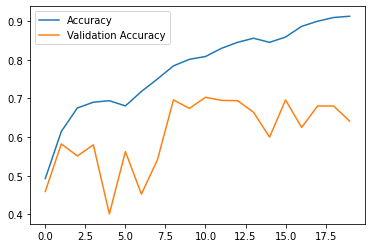

In [72]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

(1, 48, 48, 3)


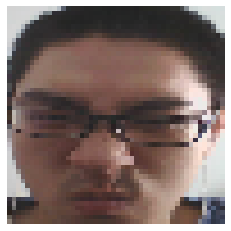

[[7.7608548e-02 1.0593403e-04 9.2228550e-01]] 
 sad


In [25]:
#img = cv2.imread("./angry999.png")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.resize(img, (48, 48))
img = prepareImage("./drive/MyDrive/Colab Notebooks/Capstone Project/Test Photo/angry9003.png")
img = np.expand_dims(img, axis=0)
print(img.shape)

plt.imshow(img[0])
plt.axis("off")
plt.show()

prediction = model.predict(img)
print(prediction, "\n", expression[np.argmax(prediction)])

In [73]:
#testDir = "./Facial Expression Dataset/test/"
testDir = "./Facial Expression Dataset Cleaned/test/"
#expression = ["angry", "happy", "neutral", "sad"]
#expression = ["angry", "happy"]

imgTest = []
labelTest = []

numOfData = 500
for label, labelName in enumerate(expression) :
    for i in tqdm(os.listdir(testDir + labelName)[:numOfData]) :
        imgTest.append(prepareImage(os.path.join(testDir, labelName, i)))
        tempLabel = np.zeros(len(expression))
        tempLabel[label] = 1
        labelTest.append(tempLabel)
        #labelTrain.append(label)
        #imgTrain = np.concatenate((imgTrain, prepareImage(trainDir + i + "/" + j)))

imgTest = np.array(imgTest)
labelTest = np.array(labelTest)

prediction = model.predict(imgTest)
cm = confusion_matrix(np.argmax(labelTest, axis=1), np.argmax(prediction, axis=1))
#for i in prediction :
#    print(np.argmax(i))

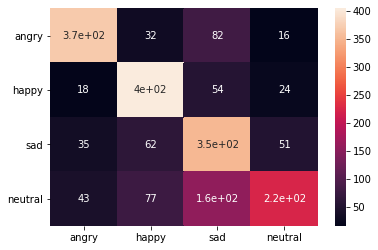

In [74]:
sns.heatmap(cm, annot=True, xticklabels=expression, yticklabels=expression)
plt.yticks(rotation=0)
plt.show()

Label : happy    Prediction : happy


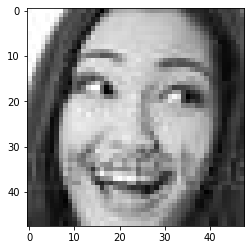

In [75]:
index = 509
#print(prediction)
print("Label :", expression[np.argmax(labelTest[index])], "   Prediction :", expression[np.argmax(prediction[index])])
plt.imshow(imgTest[index])
plt.show()

In [76]:
model.save("./model happy angry sad neutral good with cleaned dataset")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./model happy angry sad neutral good with cleaned dataset/assets


In [78]:
! zip -rq "model happy angry sad good with cleaned dataset.zip" "model happy angry sad good with cleaned dataset"

In [81]:
converter = tf.lite.TFLiteConverter.from_saved_model("./model happy angry sad good with cleaned dataset") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model happy angry sad good with cleaned dataset.tflite', 'wb') as f:
  f.write(tflite_model)